# Importing secondary structure dataset

In [1]:
import pandas as pd
import numpy as np
import sklearn as sl
import gc
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import os

thresh = 0.65

In [2]:
data = np.load('cullpdb+profile_5926_filtered.npy.gz', allow_pickle=False)
print(data.shape)
reshaped = data.reshape(np.shape(data)[0], 700, 57)
print(reshaped.shape)

(5365, 39900)
(5365, 700, 57)


# Identifying our desired protein

In [3]:
desired_sequence = 'MEPKVAELKQKIEDTLCPFGFEVYPFQVAWYNELLPPAFHLPLPGPTLAFLVLSTPAMFDRALKPFLQSCHLRMLTDPVDQCVAYHLGRVRESLPELQIEIIADYEVHPNRRPKILAQTAAHVAGAAYYYQRQDVEADPWGNQRISGVCIHPRFGGWFAIRGVVLLPGIEVPDLPPRKPHDCVPTRADRIALLEGFNFHWRDWTYRDAVTPQERYSEEQKAYFSTPPAQRLALLGLAQPSEKPSSPSPDLPFTTPAPKKPGNPSRARSWLSPRVSPPASPGP'
all_residues = ['A', 'C', 'E', 'D', 'G', 'F', 'I', 'H', 'K', 'M', 'L', 'N', 'Q', 'P', 'S', 'R', 'T', 'W', 'V', 'Y', 'X','']

# convert the desired sequence in a sequence of indices
sequence_indices = [all_residues.index(residue) for residue in desired_sequence]

print(sequence_indices[:10])  # Show first 10 integers


[9, 2, 13, 8, 18, 0, 2, 10, 8, 12]


In [4]:
sequences = []


for i in range(np.shape(reshaped)[0]):
    temp = reshaped[i,:,:22]
    temp = np.argmax(temp, axis = 1)
    
    sequences_letters = [all_residues[idx] for idx in temp]
    sequences.append(sequences_letters)

print(np.shape(sequences))

(5365, 700)


In [5]:
compressed_sequences = [''.join(row) for row in sequences]
print(np.shape(compressed_sequences))

(5365,)


In [6]:

matches = [i for i, seq in enumerate(compressed_sequences) if desired_sequence in seq]

if matches:
    print(f"MMACHC sequence found at index: {matches}")
else:
    print("MMACHC sequence not found in dataset.")


MMACHC sequence not found in dataset.


# Produce MMACHC data
Since in CB513 dataset our desired protein was not found, we now want to produce a consistent record with our available dataset

In [7]:
import numpy as np
from Bio import SeqIO
from Bio.PDB import PDBParser, DSSP

# --- Constants ---
all_residues = ['A','C','E','D','G','F','I','H','K','M','L','N','Q','P','S','R','T','W','V','Y','X']
no_seq_idx = 21  # index of 'NoSeq' in features [0–22)
secmap = {'L':0, 'B':1, 'E':2, 'G':3, 'I':4, 'H':5, 'S':6, 'T':7}
feature_profile_order = list("ACDEFGHIKLMNPQRSTVWXY")

# --- 1. Load MMACHC FASTA sequence ---
record = SeqIO.read("data/protein.faa", "fasta")
seq = str(record.seq)
L = len(seq)

# --- 2. Initialize feature matrix (700 x 57) ---
MMACHC = np.zeros((700, 57), dtype=float)

# --- 3. One-hot encode residues [0:22] ---
for j, aa in enumerate(seq):
    idx = all_residues.index(aa) if aa in all_residues else no_seq_idx
    MMACHC[j, idx] = 1

# --- 4. DSSP secondary structure [22:31] and solvent accessibility [33:35] ---
parser = PDBParser(QUIET=True)
structure = parser.get_structure("MMACHC", "data/3sc0.pdb")
model = structure[0]
chain = list(model.get_chains())[0]  # assumes single chain
dssp = DSSP(model, "data/3sc0.pdb")

# Get maximum RSA (relative solvent accessibility) for normalization
max_rsa = max([d[3] for d in dssp.property_dict.values() if d[3] is not None] + [1])  # avoid div by 0

for i, ((chain_id, res_id), dssp_data) in enumerate(dssp.property_dict.items()):
    if i >= L:
        break
    # Secondary structure
    ss = dssp_data[2]
    ss_idx = secmap.get(ss, 8)  # 'NoSeq' index if not found
    MMACHC[i, 22 + ss_idx] = 1

    # Solvent accessibility
    abs_acc = dssp_data[3]
    rel_acc = abs_acc / max_rsa if max_rsa > 0 else 0
    MMACHC[i, 33] = 1 if abs_acc <= 15 else 0
    MMACHC[i, 34] = 1 if rel_acc > 0.15 else 0

# --- 5. N- and C-terminal indicators [31:33] ---
MMACHC[0, 31] = 1
MMACHC[L-1, 32] = 1

# --- 6. Add PSSM profile [35:56] ---
def parse_pssm(pssm_file, L, aa_order):
    # Only keep standard 20 amino acids for PSSM
    aa_order_20 = [aa for aa in aa_order if aa in "ACDEFGHIKLMNPQRSTVWY"]
    pssm_matrix = np.zeros((L, 20), dtype=float)
    with open(pssm_file, "r") as f:
        lines = f.readlines()
    for i, line in enumerate(lines):
        if line.startswith('Last position-specific scoring matrix computed'):
            start = i + 2
            break
    else:
        raise ValueError("PSSM matrix not found in file.")
    pssm_raw = []
    for line in lines[start:]:
        parts = line.strip().split()
        if len(parts) < 22:
            continue
        scores = [int(parts[j]) for j in range(2, 22)]
        pssm_raw.append(scores)
        if len(pssm_raw) >= L:
            break
    pssm_array = np.array(pssm_raw, dtype=float)
    min_score, max_score = pssm_array.min(), pssm_array.max()
    if max_score > min_score:
        pssm_array = (pssm_array - min_score) / (max_score - min_score)
    blast_order = list("ACDEFGHIKLMNPQRSTVWY")
    idx_map = [blast_order.index(x) for x in aa_order_20]
    pssm_reordered = pssm_array[:, idx_map]
    return pssm_reordered

pssm_profile = parse_pssm("mmachc.pssm", L, feature_profile_order)
MMACHC[:L, 35:55] = pssm_profile

print(f"MMACHC array shape: {MMACHC.shape}")

MMACHC array shape: (700, 57)


In [8]:
MMACHC[281]

array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 1.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       1.    , 0.    , 0.    , 0.25  , 0.1875, 0.1875, 0.1875, 0.125 ,
       0.25  , 0.25  , 0.1875, 0.1875, 0.125 , 0.125 , 0.25  , 0.125 ,
       0.0625, 0.8125, 0.25  , 0.25  , 0.0625, 0.125 , 0.1875, 0.    ,
       0.    ])

In [9]:
reshaped.shape

(5365, 700, 57)

In [10]:
# extra training points
def augment_point_with_noise(point, n_samples, noise_range=(-0.001, 0.001)):
    
    point = np.array(point)
    augmented = np.tile(point, (n_samples, 1))  # replicate original

    # Replace noise columns with uniform random values each sample
    noise_min, noise_max = noise_range
    noise_shape = (n_samples, 20)  # cols 36 to 55 inclusive: 20 columns total
    random_noise = np.random.uniform(noise_min, noise_max, size=noise_shape)
    augmented[:, 36:56] = random_noise

    augmented[augmented > 1] = 1
    augmented[augmented < 0] = 0
    
    return augmented

In [11]:
n_samples = np.random.randint(low=100, high=200)
mask = np.where(MMACHC[:,48] != 0)[0]  # note the [0] to get indices

to_aug = MMACHC[mask, :]  # shape (num_rows, features)
num_rows, num_features = to_aug.shape

extra_points = np.zeros((n_samples, num_rows, num_features))

for i in range(n_samples):
    for j in range(num_rows):
        augmented = augment_point_with_noise(to_aug[j,:], n_samples=1)  # shape (1, features)
        extra_points[i, j, :] = augmented[0]  # get 1D array from result

print(extra_points.shape)  # (n_samples, num_rows, num_features)


(197, 282, 57)


In [12]:

rows = []

for i in (range(np.shape(extra_points)[0])):
    prot_id = i + 1032
    for j in (range(np.shape(extra_points)[1])):
        row = extra_points[i,j,:] # taking all the features
        rows.append({
            'prot_id': i, 
            **{f'feat_{k}': row[k] for k in range(np.shape(extra_points)[2])}
        })

df_extra = pd.DataFrame(rows)


# Compute cosine similarity with MMACHC

In [13]:
def pssm_similarity(pssm1, pssm2):
    p1 = pssm1.flatten()
    p2 = pssm2.flatten()
    return np.corrcoef(p1, p2)[0, 1]

In [14]:
# target
print(np.shape(reshaped))
MMACHC_pssm = MMACHC.flatten() 
similarities = np.zeros(np.shape(reshaped)[0])
for i in range(np.shape(reshaped)[0]):
    pssm = reshaped[i,:,:].flatten()
    similarities[i] = np.corrcoef(MMACHC_pssm, pssm)[0, 1]


kept_indices = np.where(abs(similarities) > max(similarities) * thresh)[0]

reshaped = reshaped[kept_indices,:,:]
print(np.shape(reshaped))

(5365, 700, 57)
(1000, 700, 57)


# Preparing the data

In [15]:
# proteins univoque ids
rows = []

kept_set = set(kept_indices)
for i in range(reshaped.shape[0]):
    for j in (range(np.shape(reshaped)[1])):
        row = reshaped[i,j,:] # taking all the features
        rows.append({
            'prot_id': i, 
            **{f'feat_{k}': row[k] for k in range(np.shape(reshaped)[2])}
        })

df = pd.DataFrame(rows)

df = df.drop(columns = 'feat_21')
print(df.shape,'is shape before filtering')

#df = pd.concat([df,df_extra], ignore_index = True)
print(df.shape,'is shape after augmenting')


# renaming columns
all_residues = ['A','C','E','D','G','F','I','H','K','M','L','N','Q','P','S','R','T','W','V','Y','X','NoSeq']
all_structures = ['L', 'B', 'E', 'G', 'I', 'H', 'S', 'T', 'NoSeqS']
df.rename(columns={df.columns[i]: all_residues[i-1] for i in range(1, 23)}, inplace=True)
df.rename(columns={df.columns[i]: all_structures[i-23] for i in range(23, 32)}, inplace=True)

# drop columns where NoSeq is 1
mask = np.where(df['NoSeq'] == 0)[0]
df = df.iloc[mask]
df = df.drop(columns = ['NoSeq','NoSeqS']) # no need to keep these col
print(df.shape,'is shape after filtering')
df

(700000, 57) is shape before filtering
(700000, 57) is shape after augmenting
(645605, 55) is shape after filtering


,prot_id,A,C,E,D,G,F,I,H,K,...,feat_47,feat_48,feat_49,feat_50,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.083938,0.126751,0.073101,0.922012,0.981476,0.176535,0.018343,0.500000,0.039166,0.0
5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.025831,0.030472,0.020036,0.086274,0.361237,0.995679,0.012128,0.268941,0.050211,0.0
6,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005325,0.021881,0.015828,0.081660,0.020233,0.023203,0.428004,0.268941,0.999875,0.0
8,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.977246,0.060654,0.031371,0.396517,0.119203,0.085489,0.009013,0.500000,0.019840,0.0
10,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.352059,0.999629,0.220974,0.217550,0.166589,0.012869,0.012370,0.268941,0.022533,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699995,999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
699996,999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
699997,999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
699998,999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0


In [16]:
# features are first 20 columns (+1 of protein id), labels the last 8  
# extra features are from col 30 onwards (remove the last one since is empty)
X = df.values[:,:21]
Y = df.values[:,22:30]
X_2 = df.values[:,30:51]

# fraction of points in test size
frac = 0.2
prot_indices = np.arange(np.shape(reshaped)[0])
np.random.shuffle(prot_indices)
val_proteins = prot_indices[:int(frac * len(prot_indices))]
train_proteins = prot_indices[int(frac * len(prot_indices)):]

mask_train = np.isin(X[:,0], train_proteins)
mask_val = np.isin(X[:,0], val_proteins)

X_train = X[mask_train]
Y_train = Y[mask_train]
print(Y_train.sum(axis = 1).mean(axis = 0))
Y_train = np.argmax(Y_train, axis = 1) # convert to classes
#X_train = X_train[:,1:] # remove first column (useless now)

X_val = X[mask_val]
Y_val = Y[mask_val]
print(Y_val.sum(axis = 1).mean(axis = 0))
Y_val = np.argmax(Y_val, axis = 1) # convert to classes
#X_val = X_val[:,1:] # remove first column (useless now)
print('Features X:',np.shape(X))
print('Labels Y (before converting):',np.shape(Y))
print('Extra features X_2:',np.shape(X_2))

1.0
1.0
Features X: (645605, 21)
Labels Y (before converting): (645605, 8)
Extra features X_2: (645605, 21)


In [17]:
classes = ['L', 'B', 'E', 'G', 'I', 'H', 'S', 'T']
print(f'Classes\t\t\t\t   ',classes)
print('counts of classes in train set (%):',(np.unique(Y_train, return_counts = True)[1]/sum(np.unique(Y_train, return_counts = True)[1])).round(3)*100)
print('counts of classes in valid set (%):',(np.unique(Y_val, return_counts = True)[1]/sum(np.unique(Y_val, return_counts = True)[1])).round(3)*100)
# convert Y in multiclass
Y = np.argmax(Y, axis = 1)
# convert to 3 class
# Define mapping from 8-class DSSP indices to Q3: H=0, E=1, C=2
dssp8_to_q3 = {
    5: 0,  # H
    3: 0,  # G
    4: 0,  # I
    2: 1,  # E
    1: 1,  # B
    0: 2,  # L
    6: 2,  # S
    7: 2   # T
}
classes = ['H','E','C']
Y_q3 = np.vectorize(dssp8_to_q3.get)(Y)
Y = Y_q3
print(f'\nUnique contents of Y:',np.unique(Y_q3))
# occurrences
clas, counts = np.unique(Y, return_counts = True)
counts = counts / sum(counts) * 100
print(f"Classes:\t\t\t {clas}")
print(f"Occurrences train+valid (%): {counts}")

Classes				    ['L', 'B', 'E', 'G', 'I', 'H', 'S', 'T']
counts of classes in train set (%): [ 0.4  9.4  1.9  0.  16.1  3.7  5.  63.5]
counts of classes in valid set (%): [ 0.4  9.7  1.7  0.  15.   3.8  5.  64.4]

Unique contents of Y: [0 1 2]
Classes:			 [0 1 2]
Occurrences train+valid (%): [19.58147784 11.27624476 69.1422774 ]


In [18]:
# merge X and X_2 to make a unique X set
final_X = np.hstack((X,X_2))
print('X_final:',np.shape(final_X))
X = final_X

X_final: (645605, 42)


In [19]:
gc.collect()

0

## Preparing test set (MMACHC)

In [20]:
# prepare test set
X_test = MMACHC[:,:21]
print(np.shape(X_test))
X_2_test = MMACHC[:,30:50]
final_X = np.hstack((X_test,X_2_test))
X_test = final_X
mask = np.where(final_X[:,37] != 0)[0]
X_test = X_test[mask,:]
print('X_final_test:',np.shape(X_test))

import difflib

# labels
import json
import numpy as np

# Load the JSON data from the file
with open("data/Q9Y4U1.json", "r") as f:
    data = json.load(f)

# First, identify the overall protein length from the chain feature.
# We assume that there is one 'Chain' feature with a start and end.
chain_feature = None
for feature in data['features']:
    if feature.get('type') == "Chain":
        chain_feature = feature
        break

if chain_feature is None:
    raise ValueError("Chain feature with start and end positions not found.")
    
start = chain_feature['location']['start']['value']
end = chain_feature['location']['end']['value']
protein_length = end - start + 1

# Create a default numpy array filled with 'C' (for Coil, i.e. undefined structure)
ss_array = np.full(protein_length, 'C', dtype='<U1')

# Function to update the secondary structure array for a given range and code
def assign_structure(feature, code):
    loc = feature.get("location", {})
    s = loc.get("start", {}).get("value")
    e = loc.get("end", {}).get("value")
    if s is None or e is None:
        return
    # Convert residue numbers to 0-index (assuming positions in the file start at 1)
    ss_array[s- start : e- start + 1] = code

# Process all features that correspond to secondary structure:
# We will check for 'Helix', 'Beta strand', and 'Turn'
for feature in data['features']:
    ft = feature.get("type")
    if ft == "Helix":
        assign_structure(feature, "H")
    elif ft == "Beta strand":
        assign_structure(feature, "E")
    elif ft == "Turn":
        assign_structure(feature, "T")
        
#print("Secondary structure array:")
#print(ss_array)
classes = ['H','E','C','T']
# convert the desired sequence in a sequence of indices
ss_sequence = np.array([classes.index(residue) for residue in ss_array])
# remove 3 (T == C)
mask = np.where(ss_sequence == 3)[0]
ss_sequence[mask] = 2

classes_test, class_occurrences_test = np.unique(ss_sequence, return_counts = True)
print(f"Classes:\t\t\t {classes_test}")
class_occurrences_test = class_occurrences_test / sum(class_occurrences_test) * 100
print(f"Percentage of occurrence (%): {class_occurrences_test}")
Y_test = ss_sequence
print(np.shape(Y_test))

(700, 21)
X_final_test: (282, 41)
Classes:			 [0 1 2]
Percentage of occurrence (%): [37.58865248 17.37588652 45.03546099]
(282,)


In [21]:
# create sliding windows
def apply_sliding_window(X, Y, window_size):
    half_w = window_size // 2
    prot_ids = np.unique(X[:, 0])
    X_windows = []
    Y_labels = []

    for pid in prot_ids:
        prot_mask = X[:, 0] == pid
        prot_feats = X[prot_mask][:, 1:]  # remove prot_id
        prot_labels = Y[prot_mask]

        L = len(prot_feats)
        # pad with zeros on both sides
        pad = np.zeros((half_w, prot_feats.shape[1]))
        padded_feats = np.vstack([pad, prot_feats, pad])

        for i in range(L):
            window = padded_feats[i:i+window_size].flatten()
            label = prot_labels[i]
            X_windows.append(window)
            Y_labels.append(label)

    X_windows = np.array(X_windows)
    Y_labels = np.array(Y_labels)
    print("X_windows shape:", X_windows.shape)  # Should be (N, window_size * D)
    print("Y_labels shape:", Y_labels.shape)    # Should be (N,)
    return np.array(X_windows), np.array(Y_labels)


In [22]:
print(np.shape(X),np.shape(Y))
print(np.shape(X_test),np.shape(Y_test))

(645605, 42) (645605,)
(282, 41) (282,)


# Model

### Torch functions

In [23]:
import torch
from torch.utils.data import Dataset

class SlidingWindowProteinDataset(Dataset):
    def __init__(self, X, Y, window_size, is_test):
        if(is_test == False):
            self.samples = []
            self.labels = []
    
            half_w = window_size // 2
            prot_ids = np.unique(X[:, 0])
    
            for pid in prot_ids:
                prot_mask = X[:, 0] == pid
                prot_feats = X[prot_mask][:, 1:].astype(np.float32)  # exclude prot_id
                prot_labels = Y[prot_mask]
                L = len(prot_feats)
    
                # Pad
                pad = np.zeros((half_w, prot_feats.shape[1]), dtype=np.float32)
                padded_feats = np.vstack([pad, prot_feats, pad])
    
                for i in range(L):
                    window = padded_feats[i:i+window_size]
                    label = prot_labels[i]
                    self.samples.append(window)
                    self.labels.append(label)
                    
        if(is_test == True):
            self.samples = []
            self.labels = []
    
            half_w = window_size // 2
    
            prot_feats = X[:,:].astype(np.float32)  # exclude prot_id
            prot_labels = Y
            #print(prot_labels)
            L = len(prot_feats)
    
            # Pad
            pad = np.zeros((half_w, prot_feats.shape[1]), dtype=np.float32)
            padded_feats = np.vstack([pad, prot_feats, pad])
    
            for i in range(L):
                window = padded_feats[i:i+window_size]
                label = prot_labels[i]
                self.samples.append(window)
                self.labels.append(label)
        

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x = torch.tensor(self.samples[idx])  # shape: (window_size, feat_dim)
        x = x.permute(1, 0)  # shape: (feat_dim, window_size)
        y = torch.tensor(self.labels[idx], dtype = torch.long)
        return x, y

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNClassifier(nn.Module):
    def __init__(self, in_channels, out_classes, conv_filters, hidden_sizes):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=conv_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=conv_filters, out_channels=conv_filters, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.3)
        layers = []
        input_dim = conv_filters
        for h in hidden_sizes:
            layers.append(nn.Linear(input_dim, h))
            input_dim = h
        self.hidden_layers = nn.ModuleList(layers)        
        self.fc_out = nn.Linear(input_dim, out_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = x.mean(dim=2)
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        x = self.fc_out(x)
        return x

# Training loop

Training the model with epochs 20, window sizes 7, hidden layers [128, 64, 32], learning rate 0.001


Epoch 1/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/4033 [00:00<?, ?it/s]

New best score: 0.899


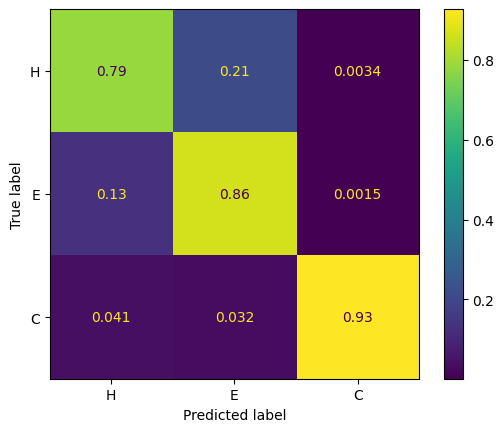

Training the model with epochs 20, window sizes 11, hidden layers [128, 64, 32], learning rate 0.001


Epoch 1/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/4033 [00:00<?, ?it/s]

New best score: 0.903


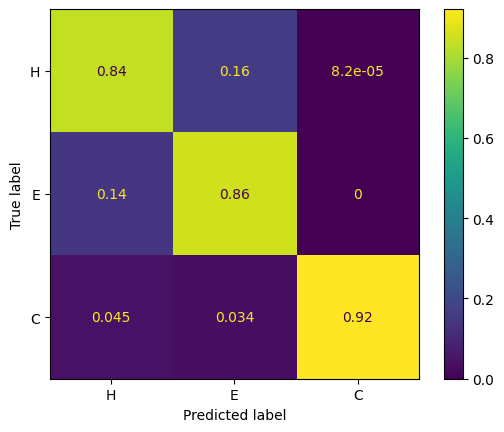

Training the model with epochs 20, window sizes 15, hidden layers [128, 64, 32], learning rate 0.001


Epoch 1/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/4033 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/4033 [00:00<?, ?it/s]

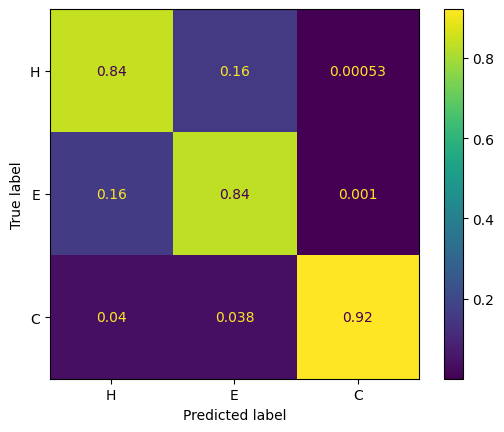

Best final score is 0.9030964182223565 with params {'ws': 11, 'hl': [128, 64, 32], 'max_iters': 20, 'lr': 0.001}


In [25]:
from tqdm.notebook import tqdm
import torch.optim as optim
from torch.utils.data import WeightedRandomSampler, DataLoader
from sklearn.metrics import f1_score

# Grid search
window_sizes = [7, 11, 15]
hl_sizes = [[128, 64, 32]]#, [128, 64]]
max_iters = [20]
learning_rates = [1e-3]
best_score = -1
filters = 32

num_features = X.shape[1]-1
num_classes = len(np.unique(Y))  # or Y.max() + 1

for ws in window_sizes:
    for hl in hl_sizes:
        for epochs in max_iters:
            for lr in learning_rates:
                # Dataset instances
                train_dataset = SlidingWindowProteinDataset(X[mask_train], Y[mask_train], window_size=ws, is_test = False)
                val_dataset = SlidingWindowProteinDataset(X[mask_val], Y[mask_val], window_size=ws, is_test = False)
                
                train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
                val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
                
                print(f"Training the model with epochs {epochs}, window sizes {ws}, hidden layers {hl}, learning rate {lr}")
                model = CNNClassifier(
                    in_channels=num_features,
                    out_classes=num_classes,
                    conv_filters=filters, 
                    hidden_sizes = hl
                )
                optimizer = optim.Adam(model.parameters(), lr=lr)
                # class balance
                # Compute class frequencies
                class_counts = np.bincount(Y[mask_train])
                class_weights = 1.0 / (class_counts + 1e-6)  # avoid div by zero
                class_weights = class_weights / class_weights.sum()  # normalize
                
                # Convert to tensor
                class_weights = torch.tensor(class_weights, dtype=torch.float32)
                
                # Use class_weights in loss
                criterion = nn.CrossEntropyLoss(weight=class_weights)
    
                for epoch in range(epochs):
                    model.train()
                    running_loss = 0.0
                    train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
                    for xb, yb in train_iterator:
                        optimizer.zero_grad()
                        preds = model(xb)
                        loss = criterion(preds, yb)
                        loss.backward()
                        optimizer.step()
                        
                        running_loss += loss.item()
                        train_iterator.set_postfix(loss=running_loss / (train_iterator.n + 1))
                
                # Validation loop should be here before concatenating preds/labels!
                all_preds, all_labels = [], []
                with torch.no_grad():
                   for xb, yb in val_loader:
                       out = model(xb)
                       all_preds.append(out.argmax(dim=1).cpu())
                       all_labels.append(yb.cpu())
                all_preds = torch.cat(all_preds).numpy()
                all_labels = torch.cat(all_labels).numpy()
                score = f1_score(all_labels, all_preds, average='weighted')
                if(score > best_score):
                    print(f'New best score: {round(score,3)}')
                    best_score = score
                    best_params = {
                        'ws':ws,
                        'hl':hl,
                        'max_iters':epochs,
                        'lr':lr
                    }
            classes = ['H','E','C']
            cm = sl.metrics.confusion_matrix(all_labels, all_preds)
            cm = cm / cm.sum(axis=1, keepdims=True)
                
                
            disp = sl.metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                                        display_labels = classes
                                                        )
            disp.plot()
                
            plt.show()

print(f"Best final score is {best_score} with params {best_params}")



# BEST MODEL RETRAINING

In [26]:
np.shape(X_test)

(282, 41)

Training the final model with epochs 20, window sizes 11, hidden layers [128, 64, 32]


Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

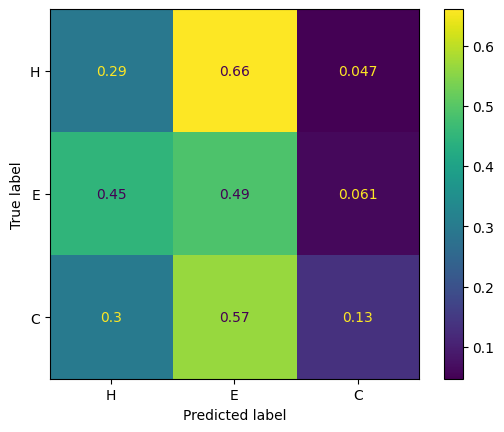

In [27]:
from tqdm.notebook import trange
from sklearn.metrics import accuracy_score 

device = "cuda:0" if torch.cuda.is_available() else "cpu"
# retrieve best params
ws = best_params['ws']
hl = best_params['hl']
mi = best_params['max_iters'] 
lr = best_params['lr']

losses = []

# Dataset instances
train_dataset = SlidingWindowProteinDataset(X[mask_train], Y[mask_train], window_size=ws, is_test = False)
val_dataset = SlidingWindowProteinDataset(X[mask_val], Y[mask_val], window_size=ws, is_test = False)
test_dataset = SlidingWindowProteinDataset(X_test, Y_test, window_size=ws, is_test= True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size = 282, shuffle = False)

            
print(f"Training the final model with epochs {epochs}, window sizes {ws}, hidden layers {hl}")
best_model = CNNClassifier(
    in_channels=num_features,
    out_classes=num_classes,
    conv_filters=filters,
    hidden_sizes = hl
    )
best_model.to(device)

optimizer = optim.Adam(best_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

epoch_iterator = trange(mi, desc="Training Epochs")

train_losses = []
val_losses = []
test_accuracies = []

for i in epoch_iterator:
    best_model.train()
    running_loss = 0.0

    losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = best_model(xb)
        loss = criterion(preds, yb)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    losses = []
    running_loss = 0.0
    
    # Validation
    all_preds, all_labels = [], []
    best_model.eval()
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = best_model(xb)
            all_preds.append(out.argmax(dim=1).cpu())
            all_labels.append(yb.cpu())
            loss = criterion(out, yb)
            losses.append(loss.item())
            running_loss += loss.item()

    #score = f1_score(all_labels, all_preds, average='weighted')
    avg_loss = running_loss / len(val_loader)
    val_losses.append(avg_loss)
    #epoch_iterator.set_postfix(loss=avg_loss, f1=score)
    
# Test evaluation
best_model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = best_model(xb)
        test_preds.append(out.argmax(dim=1).cpu())
        test_labels.append(yb.cpu())

# concatenate into one long vector
test_preds = torch.cat(test_preds).numpy()
test_labels = torch.cat(test_labels).numpy()

cm = sl.metrics.confusion_matrix(test_labels,test_preds)
cm = cm / cm.sum(axis=1, keepdims=True)

classes = ['H','E','C']
disp = sl.metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                        display_labels = classes
                                        )
disp.plot()

plt.show()

In [28]:
len(np.where(test_preds == test_labels))/len(test_dataset)*100

0.3546099290780142

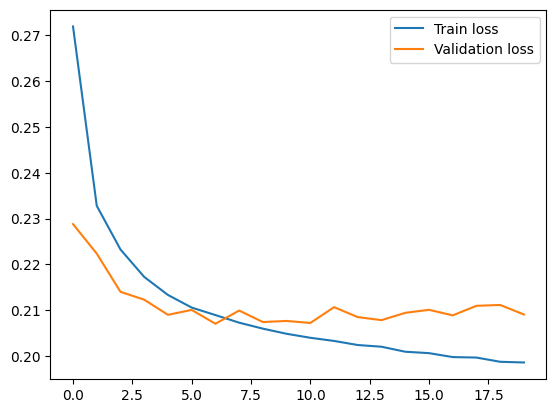

In [30]:
arr_epochs = np.arange(20)
plt.plot(arr_epochs, train_losses, label = 'Train loss')
plt.plot(arr_epochs, val_losses, label = 'Validation loss')
plt.legend()
plt.show()



In [32]:
print(np.unique(test_labels, return_counts = True))

(array([0, 1, 2]), array([106,  49, 127]))


In [33]:
import numpy as np
import matplotlib.pyplot as plt

def plot_secondary_structure_multirow(real, pred, n_rows=4):
    assert len(real) == len(pred), "Sequences must be the same length"
    length = len(real)
    colors = {0: 'blue', 1: 'orange', 2: 'green'}
    class_names = {0: 'H (Helix)', 1: 'E (Sheet)', 2: 'C (Coil)'}
    
    # Calculate length per row (ceil division)
    row_len = (length + n_rows - 1) // n_rows
    
    fig, axes = plt.subplots(n_rows, 1, figsize=(row_len / 5, 3 * n_rows), sharex=False)
    if n_rows == 1:
        axes = [axes]
    
    for r in range(n_rows):
        ax = axes[r]
        start = r * row_len
        end = min(start + row_len, length)
        
        segment_real = real[start:end]
        segment_pred = pred[start:end]
        segment_len = end - start
        
        mismatch = (np.array(segment_real) != np.array(segment_pred))
        
        # Red background on mismatch
        for i in range(segment_len):
            if mismatch[i]:
                ax.axvspan(i, i + 1, color='red', alpha=0.3)
        
        # Real sequence bars (top)
        for i, val in enumerate(segment_real):
            ax.bar(i, 1, color=colors[val], edgecolor='black', align='edge')
        
        # Predicted sequence bars (bottom)
        for i, val in enumerate(segment_pred):
            ax.bar(i, 0.4, color=colors[val], edgecolor='black', align='edge', bottom=-0.5)
        
        ax.set_ylim(-1, 1.2)
        ax.set_xlim(0, segment_len)
        ax.set_yticks([0, -0.3])
        ax.set_yticklabels(['Real', 'Predicted'])
        ax.set_xticks(np.arange(0, segment_len, max(1, segment_len // 10)))
        ax.set_ylabel(f'Row {r+1}')
    
    axes[-1].set_xlabel('Residue position (per row)')
    fig.suptitle('Secondary Structure Prediction vs Real (4 rows)')
    
    # Create legend
    legend_patches = [plt.Line2D([0], [0], color=colors[k], lw=8, label=class_names[k]) for k in colors]
    legend_patches.append(plt.Rectangle((0,0),1,1, color='red', alpha=0.3, label='Mismatch'))
    axes[0].legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.15, 1))
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('pred_seq.jpg')
    plt.show()



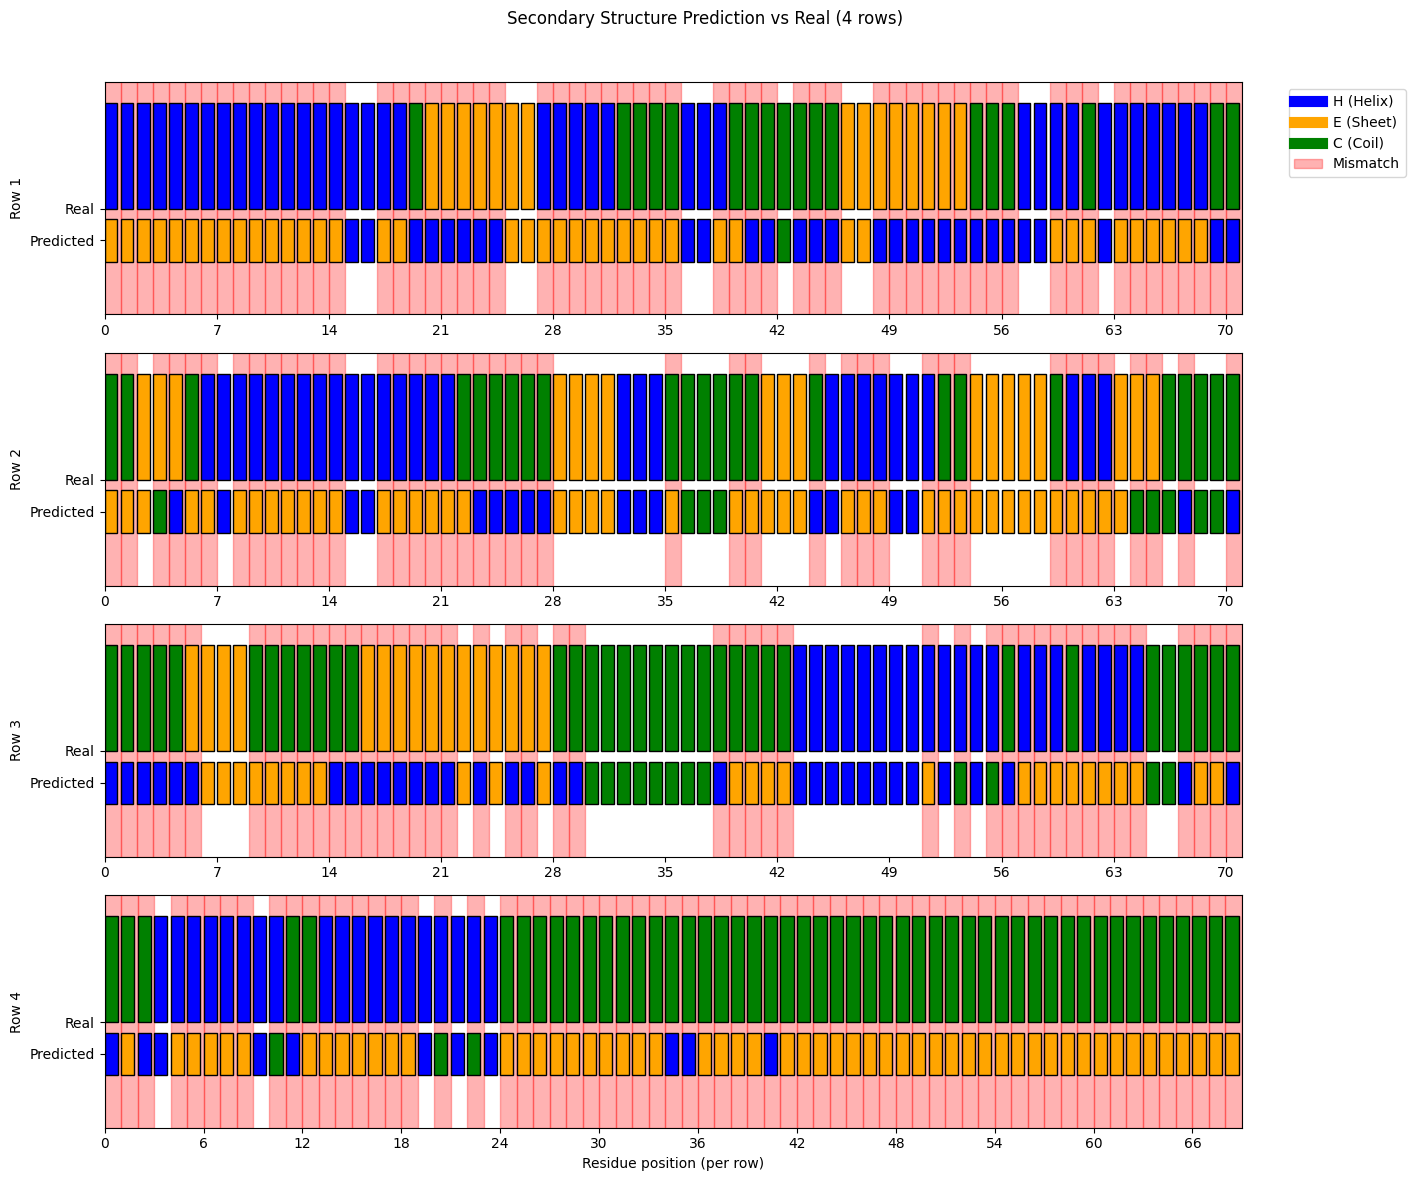

In [34]:
plot_secondary_structure_multirow(test_labels, test_preds)

In [35]:
best_model.eval()
all_preds, all_labels, all_probs = [], [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = best_model(xb)
        probs = torch.softmax(out, dim = 1)
        all_preds.append(out.argmax(dim=1).cpu())
        all_labels.append(yb.cpu())
        all_probs.append(probs.cpu())
        loss = criterion(out, yb)
        losses.append(loss.item())
        running_loss += loss.item()
            
        
            
    
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    all_probs = torch.cat(all_probs).numpy()


In [36]:
(all_probs.max(axis = 1))

array([0.63832617, 0.67333305, 0.740473  , 0.75655955, 0.6179732 ,
       0.6464192 , 0.65494096, 0.6970127 , 0.516194  , 0.5319912 ,
       0.7127302 , 0.5787992 , 0.49810788, 0.47472188, 0.4488468 ,
       0.41653466, 0.5961903 , 0.49256647, 0.46139708, 0.42810065,
       0.43264773, 0.65194136, 0.4555981 , 0.63261056, 0.64940464,
       0.58151174, 0.7810225 , 0.9354319 , 0.95192504, 0.9246741 ,
       0.8717615 , 0.64810234, 0.47104788, 0.4702682 , 0.44807306,
       0.45485258, 0.34748462, 0.36165363, 0.36918435, 0.44169748,
       0.36878675, 0.38390914, 0.38774323, 0.3732873 , 0.4065656 ,
       0.4565523 , 0.48105696, 0.4423054 , 0.6823875 , 0.87294805,
       0.6970893 , 0.63212985, 0.7104499 , 0.83534807, 0.7791558 ,
       0.6736506 , 0.5814216 , 0.63044524, 0.5341958 , 0.6306759 ,
       0.5573878 , 0.44277385, 0.4260157 , 0.4362198 , 0.4226056 ,
       0.48310816, 0.4569837 , 0.4755298 , 0.4449969 , 0.38507706,
       0.42663333, 0.37895352, 0.40143448, 0.41650558, 0.34145

In [ ]:
len(np.where(all_labels == all_preds)[0]) / len(all_labels)